<a href="https://colab.research.google.com/github/MinsooKwak/Study/blob/main/MultiModal/Bi_modal/Bi_modal_image_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bi-Modal / Multi-task

- 2가지 모달이 모두 이미지인 경우
- Multitask : 하나가 아닌 2가지 예측을 생성
  - input : face, ear image
  - output : gender, age

Multi-task learning : 하나의 모달에서 2개 이상의 작업을 해결하려고 할 때

- 2가지의 타워를 가진 모델로, 각 타워가 다른 결과를 냄
- 2 예측의 오류를 최소화하는 방식으로 훈련

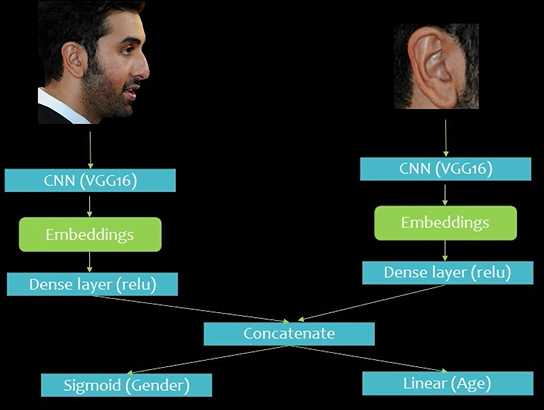

- 퓨전하는 방식 중 **'concatenating'**하는 방법을 사용
  - 얼굴과 귀에서 추출한 feature들을 활성화 함수의 결과와 함께 합쳐서 사용하게 됨
  - 합쳐서 2가지 손실 함수에 전달



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


가장 상위 폴더 정의

In [3]:
folder_path = '/content/drive/MyDrive/Study/Dataset/Profile_Ear'

In [4]:
profile_path = '/content/drive/MyDrive/Study/Dataset/Profile_Ear/Profile'
ear_path = '/content/drive/MyDrive/Study/Dataset/Profile_Ear/Ear'
profile_label_path = '/content/drive/MyDrive/Study/Dataset/Profile_Ear/Profile_Label.csv'
ear_label_path = '/content/drive/MyDrive/Study/Dataset/Profile_Ear/Ear_Label.csv'

profile_labels= pd.read_csv(profile_label_path)
ear_labels = pd.read_csv(ear_label_path)

In [5]:
from PIL import Image
import os

for idx, row in profile_labels.iterrows():
    profile_id, age, gender = row["ProfileID"], row["Age"], row["Gender"]
    profile_path_ = os.path.join(profile_path, f"{profile_id}.png")
    profile_image = Image.open(profile_path_)
    print(f"ProfileID: {profile_id}, Age: {age}, Gender: {gender}")
    profile_image.show()

for idx, row in ear_labels.iterrows():
    ear_id, age, gender = row["EarID"], row["Age"], row["Gender"]
    ear_path_ = os.path.join(ear_path, f"{ear_id}.png")
    ear_image = Image.open(ear_path_)
    print(f"EarID: {ear_id}, Age: {age}, Gender: {gender}")
    ear_image.show()

ProfileID: 1, Age: 57, Gender: M
ProfileID: 2, Age: 67, Gender: M
ProfileID: 3, Age: 61, Gender: M
ProfileID: 4, Age: 32, Gender: F
ProfileID: 5, Age: 35, Gender: M
ProfileID: 6, Age: 51, Gender: M
ProfileID: 7, Age: 37, Gender: M
ProfileID: 8, Age: 72, Gender: M
ProfileID: 9, Age: 42, Gender: M
ProfileID: 10, Age: 52, Gender: M
ProfileID: 11, Age: 33, Gender: F
ProfileID: 12, Age: 25, Gender: F
ProfileID: 13, Age: 28, Gender: M
ProfileID: 14, Age: 35, Gender: M
ProfileID: 15, Age: 30, Gender: M
ProfileID: 16, Age: 33, Gender: F
ProfileID: 17, Age: 35, Gender: F
ProfileID: 18, Age: 45, Gender: F
ProfileID: 19, Age: 30, Gender: M
ProfileID: 20, Age: 36, Gender: F
ProfileID: 21, Age: 48, Gender: M
ProfileID: 22, Age: 17, Gender: M
ProfileID: 23, Age: 21, Gender: M
ProfileID: 24, Age: 22, Gender: F
ProfileID: 25, Age: 26, Gender: F
ProfileID: 26, Age: 43, Gender: M
ProfileID: 27, Age: 34, Gender: F
ProfileID: 28, Age: 39, Gender: F
ProfileID: 29, Age: 31, Gender: F
ProfileID: 30, Age: 28,

### Data Pre-processing

In [6]:
profile_age_labels = profile_labels['Age'].to_numpy()
profile_gender_labels = profile_labels['Gender'].to_numpy()
ear_age_labels = ear_labels['Age'].to_numpy()
ear_gender_labels = ear_labels['Gender'].to_numpy()

profile_gender_labels = np.array([0 if x == 'F' else 1 for x in profile_gender_labels])
ear_gender_labels = np.array([0 if x == 'F' else 1 for x in ear_gender_labels])

In [7]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)

age_model = Model(inputs=vgg16.input, outputs=x)

age_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

x = Flatten()(resnet50.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

gender_model = Model(inputs=resnet50.input, outputs=x)

gender_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [9]:
profile_images = []
ear_images = []

for i in range(1, 61):
    # Profile Images
    profile_img_path = f"{profile_path}/{i}.png"
    profile_img = tf.keras.preprocessing.image.load_img(profile_img_path, target_size=(320, 320))
    profile_img = tf.keras.preprocessing.image.img_to_array(profile_img)
    profile_img = tf.keras.applications.vgg16.preprocess_input(profile_img)
    profile_images.append(profile_img)

    # Ear Images
    ear_img_path = f"{ear_path}/{i}.png"
    ear_img = tf.keras.preprocessing.image.load_img(ear_img_path, target_size=(320, 320))
    ear_img = tf.keras.preprocessing.image.img_to_array(ear_img)
    ear_img = tf.keras.applications.vgg16.preprocess_input(ear_img)
    ear_images.append(ear_img)

profile_images = np.array(profile_images)
ear_images = np.array(ear_images)

In [10]:
profile_images[0]

array([[[-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ]],

       [[-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ]],

       [[-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ]],

       ...,

       [[-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [ -86.939,  -99.779, -106.68 ],
        [ -79.939,  -92.779,  -99.68 ],
        [

In [11]:
ear_images[0]

array([[[-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [ -87.939, -100.779, -107.68 ],
        [ -87.939, -100.779, -107.68 ],
        [-103.939, -116.779, -123.68 ]],

       [[-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [ -87.939, -100.779, -107.68 ],
        [ -87.939, -100.779, -107.68 ],
        [ -87.939, -100.779, -107.68 ]],

       [[-103.939, -116.779, -123.68 ],
        [ -87.939, -100.779, -107.68 ],
        [-103.939, -116.779, -123.68 ],
        ...,
        [ -70.939,  -83.779,  -90.68 ],
        [ -87.939, -100.779, -107.68 ],
        [ -87.939, -100.779, -107.68 ]],

       ...,

       [[ 102.061,   89.221,   82.32 ],
        [  85.061,   72.221,   65.32 ],
        [ 102.061,   89.221,   82.32 ],
        ...,
        [ -70.939,  -83.779,  -90.68 ],
        [ -70.939,  -83.779,  -90.68 ],
        [

In [12]:
from sklearn.model_selection import train_test_split

profile_images_train, profile_images_val, profile_age_labels_train, profile_age_labels_val, \
profile_gender_labels_train, profile_gender_labels_val = train_test_split(
    profile_images, profile_age_labels, profile_gender_labels, test_size=0.2, random_state=42)

ear_images_train, ear_images_val, ear_age_labels_train, ear_age_labels_val, \
ear_gender_labels_train, ear_gender_labels_val = train_test_split(
    ear_images, ear_age_labels, ear_gender_labels, test_size=0.2, random_state=42)

**Uni-modal**

In [13]:
early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True)

In [14]:
age_model.fit(profile_images_train, profile_age_labels_train, validation_data=(profile_images_val, profile_age_labels_val),
              batch_size=16, epochs=50, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 34s 2s/step - loss: 2643485.2500 - mse: 2643485.2500 - val_loss: 11036.3916 - val_mse: 11036.3916
Epoch 2/50
3/3 [==============================] - 1s 497ms/step - loss: 589553.1875 - mse: 589553.1875 - val_loss: 2474.8918 - val_mse: 2474.8918
Epoch 3/50
3/3 [==============================] - 1s 500ms/step - loss: 8483155.0000 - mse: 8483155.0000 - val_loss: 539.6176 - val_mse: 539.6176
Epoch 4/50
3/3 [==============================] - 1s 451ms/step - loss: 6689.7046 - mse: 6689.7046 - val_loss: 1184.0287 - val_mse: 1184.0287
Epoch 5/50
3/3 [==============================] - 1s 478ms/step - loss: 789.0574 - mse: 789.0574 - val_loss: 394.4430 - val_mse: 394.4430
Epoch 6/50
3/3 [==============================] - 1s 514ms/step - loss: 296.1004 - mse: 296.1004 - val_loss: 205.9440 - val_mse: 205.9440
Epoch 7/50
3/3 [==============================] - 1s 457ms/step - loss: 515.0148 - mse: 515.0148 - val_loss: 409.2677 - val_mse: 409.2677
Epoc

In [15]:
# Early Stopping callback setting
early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)

# model training
gender_model.fit(profile_images_train, profile_gender_labels_train, validation_data=(profile_images_val, profile_gender_labels_val),
                 batch_size=16, epochs=50, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 44s 2s/step - loss: 23.9693 - accuracy: 0.5417 - val_loss: 41.2280 - val_accuracy: 0.9167
Epoch 2/50
3/3 [==============================] - 1s 389ms/step - loss: 19.0486 - accuracy: 0.8333 - val_loss: 349.8575 - val_accuracy: 0.9167
Epoch 3/50
3/3 [==============================] - 1s 389ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 7809.5386 - val_accuracy: 0.9167
Epoch 4/50
3/3 [==============================] - 1s 381ms/step - loss: 2.8179 - accuracy: 0.9583 - val_loss: 77222.3828 - val_accuracy: 0.8333
Epoch 5/50
3/3 [==============================] - 1s 405ms/step - loss: 4.8895 - accuracy: 0.9375 - val_loss: 243124.7656 - val_accuracy: 0.9167
Epoch 6/50
3/3 [==============================] - 2s 643ms/step - loss: 14.8361 - accuracy: 0.8958 - val_loss: 10721894.0000 - val_accuracy: 0.4167


In [16]:
# Early Stopping callback setting
early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True)

# model training
age_model.fit(ear_images_train, ear_age_labels_train, validation_data=(ear_images_val, ear_age_labels_val),
                  batch_size=16, epochs=50, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 2s 566ms/step - loss: 424.9974 - mse: 424.9974 - val_loss: 187.1559 - val_mse: 187.1559
Epoch 2/50
3/3 [==============================] - 1s 473ms/step - loss: 422.5506 - mse: 422.5506 - val_loss: 163.6049 - val_mse: 163.6049
Epoch 3/50
3/3 [==============================] - 1s 431ms/step - loss: 310.1299 - mse: 310.1299 - val_loss: 166.3019 - val_mse: 166.3019
Epoch 4/50
3/3 [==============================] - 1s 428ms/step - loss: 296.7978 - mse: 296.7978 - val_loss: 200.5947 - val_mse: 200.5947
Epoch 5/50
3/3 [==============================] - 1s 490ms/step - loss: 304.4302 - mse: 304.4302 - val_loss: 158.3577 - val_mse: 158.3577
Epoch 6/50
3/3 [==============================] - 1s 463ms/step - loss: 321.8525 - mse: 321.8525 - val_loss: 159.9432 - val_mse: 159.9432
Epoch 7/50
3/3 [==============================] - 1s 439ms/step - loss: 379.8746 - mse: 379.8746 - val_loss: 199.8298 - val_mse: 199.8298
Epoch 8/50
3/3 [==================

In [17]:
# Early Stopping callback setting
early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)

# model training
gender_model.fit(ear_images_train, ear_gender_labels_train, validation_data=(ear_images_val, ear_gender_labels_val),
                     batch_size=16, epochs=50, callbacks=[early_stopping])

Epoch 1/50
3/3 [==============================] - 2s 741ms/step - loss: 22.4154 - accuracy: 0.7083 - val_loss: 99.5699 - val_accuracy: 0.9167
Epoch 2/50
3/3 [==============================] - 1s 357ms/step - loss: 3.7113 - accuracy: 0.7917 - val_loss: 8281.0918 - val_accuracy: 0.9167
Epoch 3/50
3/3 [==============================] - 1s 391ms/step - loss: 2.2539 - accuracy: 0.8750 - val_loss: 155824.7188 - val_accuracy: 0.9167
Epoch 4/50
3/3 [==============================] - 1s 353ms/step - loss: 4.9786 - accuracy: 0.8958 - val_loss: 193394.2500 - val_accuracy: 0.9167
Epoch 5/50
3/3 [==============================] - 1s 358ms/step - loss: 0.1241 - accuracy: 0.9583 - val_loss: 21847.8965 - val_accuracy: 0.9167
Epoch 6/50
3/3 [==============================] - 2s 602ms/step - loss: 0.3807 - accuracy: 0.9583 - val_loss: 11953.5781 - val_accuracy: 0.9167


**Multi-modal**

In [18]:
# profile Image Input Layer
profile_input = Input(shape=(320, 320, 3))
profile_model = VGG16(weights='imagenet', include_top=False, input_tensor=profile_input)
for layer in profile_model.layers:
    layer._name = layer.name + '_profile'

# ear Image Input Layer
ear_input = Input(shape=(320, 320, 3))
ear_model = VGG16(weights='imagenet', include_top=False, input_tensor=ear_input)
for layer in ear_model.layers:
    layer._name = layer.name + '_ear'

# profile Image Embedding Extraction
profile_output = profile_model.output
profile_output = Flatten()(profile_output)
profile_output = Dense(256, activation='relu')(profile_output)

# ear Image Embedding Extraction
ear_output = ear_model.output
ear_output = Flatten()(ear_output)
ear_output = Dense(256, activation='relu')(ear_output)

# Concatenate the two embeddings to predict Gender
concat_output = Concatenate()([profile_output, ear_output])
gender_output = Dense(1, activation='sigmoid', name='gender_output')(concat_output)

# Concatenate the two embeddings to predict Age
age_output = Dense(1, activation='linear', name='age_output')(concat_output)

# Whole Model
multi_model = Model(inputs=[profile_input, ear_input], outputs=[gender_output, age_output])

# Model Compile
multi_model.compile(loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
                     optimizer='adam', metrics={'gender_output': 'accuracy', 'age_output': 'mse'})

In [19]:
# Early Stopping callback setting
early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)

multi_model.fit([profile_images_train, ear_images_train],[profile_gender_labels_train, ear_gender_labels_train],batch_size=16, epochs=1, callbacks=[early_stopping])

3/3 [==============================] - ETA: 0s - loss: 458522.9062 - gender_output_loss: 116.8158 - age_output_loss: 458406.0938 - gender_output_accuracy: 0.2083 - age_output_mse: 458406.0938

3/3 [==============================] - 12s 768ms/step - loss: 458522.9062 - gender_output_loss: 116.8158 - age_output_loss: 458406.0938 - gender_output_accuracy: 0.2083 - age_output_mse: 458406.0938


In [20]:
multi_model.predict((profile_images_val,ear_images_val))

1/1 [==============================] - 0s 302ms/step


[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[-3304.0833],
        [-2700.4185],
        [-3047.6672],
        [-3334.5198],
        [-1979.2932],
        [-2732.5442],
        [-1813.509 ],
        [-2501.548 ],
        [-1969.8578],
        [-1713.73  ],
        [-2388.558 ],
        [-1782.2201]], dtype=float32)]